In [1]:
import pandas as pd
import tensorflow as tf
import os
import numpy as np

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
df=pd.read_csv(os.path.join('datasets','jigsaw-toxic-comment-classification-challenge','train.csv','train.csv'));

In [3]:
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [4]:
from tensorflow.keras.layers import TextVectorization

In [5]:
X=df['comment_text']
y=df[df.columns[2:]].values

In [6]:
MAX_FEATURES=200000 #size of dictionary

In [7]:
vectorizer=TextVectorization(max_tokens=MAX_FEATURES,output_sequence_length=1800,output_mode='int')

In [8]:
vectorizer.adapt(X.values)

In [9]:
vectorizer.get_vocabulary()

['',
 '[UNK]',
 'the',
 'to',
 'of',
 'and',
 'a',
 'you',
 'i',
 'is',
 'that',
 'in',
 'it',
 'for',
 'this',
 'not',
 'on',
 'be',
 'as',
 'have',
 'are',
 'your',
 'with',
 'if',
 'article',
 'was',
 'or',
 'but',
 'page',
 'my',
 'an',
 'from',
 'by',
 'do',
 'at',
 'about',
 'me',
 'so',
 'wikipedia',
 'can',
 'what',
 'there',
 'all',
 'has',
 'will',
 'talk',
 'please',
 'would',
 'its',
 'no',
 'one',
 'just',
 'like',
 'they',
 'he',
 'dont',
 'which',
 'any',
 'been',
 'should',
 'more',
 'we',
 'some',
 'other',
 'who',
 'see',
 'here',
 'also',
 'his',
 'think',
 'im',
 'because',
 'know',
 'how',
 'am',
 'people',
 'why',
 'edit',
 'articles',
 'only',
 'out',
 'up',
 'when',
 'were',
 'use',
 'then',
 'may',
 'time',
 'did',
 'them',
 'now',
 'being',
 'their',
 'than',
 'thanks',
 'even',
 'get',
 'make',
 'good',
 'had',
 'very',
 'information',
 'does',
 'could',
 'well',
 'want',
 'such',
 'sources',
 'way',
 'name',
 'these',
 'deletion',
 'pages',
 'first',
 'help'

In [12]:
vectorized_text=vectorizer(X.values)

In [13]:
vectorized_text

<tf.Tensor: shape=(159571, 1800), dtype=int64, numpy=
array([[  645,    76,     2, ...,     0,     0,     0],
       [    1,    54,  2489, ...,     0,     0,     0],
       [  425,   441,    70, ...,     0,     0,     0],
       ...,
       [32445,  7392,   383, ...,     0,     0,     0],
       [    5,    12,   534, ...,     0,     0,     0],
       [    5,     8,   130, ...,     0,     0,     0]])>

In [14]:
#MCSHBAP- map,cache,shuffle,batch,prefetch
dataset=tf.data.Dataset.from_tensor_slices((vectorized_text,y))
dataset=dataset.cache()
dataset=dataset.shuffle(160000)
dataset=dataset.batch(16)
dataset=dataset.prefetch(8) #helps bottlenecks

In [15]:
batch_x,batch_y=dataset.as_numpy_iterator().next()

In [16]:
int(len(dataset)*.7)

6981

In [17]:
train=dataset.take(int(len(dataset)*.7))
val=dataset.skip(int(len(dataset)*.7)).take(int(len(dataset)*.2))
test=dataset.skip(int(len(dataset)*.9)).take(int(len(dataset)*.1))

In [18]:
len(train),len(val),len(test)

(6981, 1994, 997)

In [19]:
train_generator=train.as_numpy_iterator()

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Embedding,Dense,Bidirectional,Dropout

In [21]:
model=Sequential()
model.add(Embedding(MAX_FEATURES+1,32))
model.add(Bidirectional(LSTM(32,activation='tanh')))
model.add(Dense(128,activation='relu'))
model.add(Dense(256,activation='relu'))
model.add(Dense(128,activation='relu'))
model.add(Dense(6,activation='sigmoid'))

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          6400032   
                                                                 
 bidirectional (Bidirection  (None, 64)                16640     
 al)                                                             
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 6)                 774       
                                                        

In [23]:
model.compile(loss='BinaryCrossentropy',optimizer='Adam') ### binarycrossentropy instead of categorical because multiple outputs can be 1

In [24]:
history=model.fit(train,epochs=5,validation_data=val)

Epoch 1/5
6981/6981 [==============================] - 770s 109ms/step - loss: 0.0621 - val_loss: 0.0457
Epoch 2/5
6981/6981 [==============================] - 637s 91ms/step - loss: 0.0456 - val_loss: 0.0397
Epoch 3/5
6981/6981 [==============================] - 618s 88ms/step - loss: 0.0405 - val_loss: 0.0355
Epoch 4/5
6981/6981 [==============================] - 605s 87ms/step - loss: 0.0359 - val_loss: 0.0313
Epoch 5/5
3901/6981 [===============>..............] - ETA: 4:05 - loss: 0.0316

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



6981/6981 [==============================] - 624s 89ms/step - loss: 0.0322 - val_loss: 0.0289


In [26]:
history.history

{'loss': [0.06213805824518204,
  0.04559556022286415,
  0.04045960307121277,
  0.035923268646001816,
  0.03222694620490074],
 'val_loss': [0.045712802559137344,
  0.039688874036073685,
  0.03545079752802849,
  0.03133034333586693,
  0.028921831399202347]}

In [27]:
import matplotlib.pyplot as plt

<Figure size 800x500 with 0 Axes>

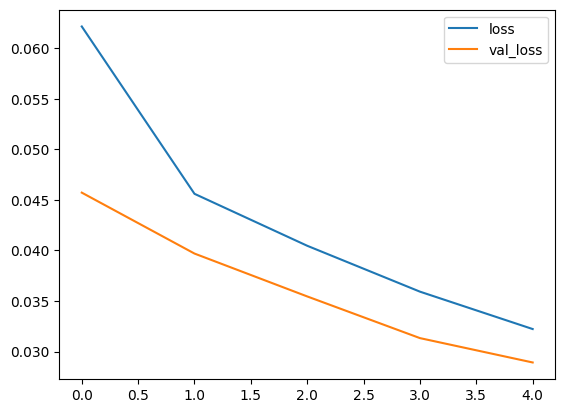

In [28]:
plt.figure(figsize=(8,5))
pd.DataFrame(history.history).plot()
plt.show()

In [29]:
batch=test.as_numpy_iterator().next()

In [30]:
input_text=vectorizer('you are pathetic')

In [31]:
model.predict(np.expand_dims(input_text,0))

1/1 [==============================] - 1s 752ms/step


array([[0.89945436, 0.02132936, 0.36492333, 0.01262645, 0.58821774,
        0.05882171]], dtype=float32)

In [33]:
batch_X,batch_Y=test.as_numpy_iterator().next()

In [34]:
(model.predict(batch_X)>0.5).astype(int)

1/1 [==============================] - 0s 52ms/step


array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

In [35]:
batch_Y

array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

In [36]:
from tensorflow.keras.metrics import Precision,Recall,CategoricalAccuracy

In [37]:
pre=Precision()
rec=Recall()
acc=CategoricalAccuracy()

In [38]:
for batch in test.as_numpy_iterator():
    X_true,y_true=batch
    yhat=model.predict(X_true)
    yhat=yhat.flatten()
    y_true=y_true.flatten()
    
    pre.update_state(yhat,y_true)
    rec.update_state(yhat,y_true)
    acc.update_state(yhat,y_true)

1/1 [==============================] - 0s 51ms/step


In [1]:
print(f'Precision {pre.result().numpy()}, Recall {rec.result().numpy()}, Accuracy {acc.result().numpy()}')

NameError: name 'pre' is not defined